# Deep Q-Learning for Solving Unity's "Banana Collectors" Problem

In this notebook we report how we experimented using deep Q-learning to solve a modified version of Unitfy's "Banana Collectors" environment, where the agent needs to navigate a 3D space to collect as many yellow bananas as possible while trying to avoid blue bananas.

This notebook contains all the code for training and running the agent.

A demo of a trained agent is shown in the gif below:

![demo](banana-dqn-demo.gif)

## Environment Setup

The dependencies can be set up by following the instructions from the [DRLND repo](https://github.com/udacity/deep-reinforcement-learning#dependencies). Once it's done, the following imports should work:

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Note that to make GPU training work on our machine, the following version of PyTorch is used:

In [3]:
torch.__version__

'1.7.0+cu110'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Additionally, we also need to download the pre-built Unity environment, which is available for different platforms:

- [Linux](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)
- [Mac OSX](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
- [Windows (32-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip)
- [Windows (64-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip)

Once downloaded and extracted, please set the path beolow according, e.g.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

In [5]:
ENV_PATH = "../Banana_Linux/Banana.x86_64"

If set up correctly, we should be able to initialize the environment:

In [6]:
env = UnityEnvironment(file_name=ENV_PATH)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Environment description

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)

Number of actions: 4
States have length: 37


## Methodology & Implementation

To solve this toy problem, we experimented with deep Q-learning as described in Mnih et al. (2015). Additionally, we also added the following extensions:

- Prioritized experience replay
- Noisy network
- Double Q-learning
- Dueling network

The details and code are presented in the following sub-sections.

### Hyper-parameters

The hyper-parameters we used is shown as the default values in the following data class:

In [9]:
!pip install -q dataclasses

from dataclasses import dataclass


@dataclass
class AgentConfig:
    batch_size: int = 256
    learning_rate: float = 3e-4
    replay_buffer_size: int = 100_000
    target_params_update_every: int = 4
    target_params_update_ratio: float = 0.005
    reward_discount_factor: float = 0.99
    reward_unroll_steps: int = 5


AgentConfig()

AgentConfig(batch_size=256, learning_rate=0.0003, replay_buffer_size=100000, target_params_update_every=4, target_params_update_ratio=0.005, reward_discount_factor=0.99, reward_unroll_steps=5)

### Prioritized experience replay

Here we use prioritized experience replay as described in Schaul et al. (2015). Specifically, we implemented the proportional priorization variant with the sum-tree data structure.

The code for the replay buffer is as follows:

In [10]:
from typing import Any, Generator, List, Tuple, Optional


class ProportionallyPrioritizedReplayBuffer:
    """A proportionally prioritized replay buffer implemented with sum-tree."""

    _curr_index: int
    _size: int
    _max_priority: float
    _sum_tree: List[float]
    _priorities: List[float]
    _samples: List[Any]

    def __init__(self, buffer_size: int):
        assert buffer_size > 1
        self._curr_index = 0
        self._size = 0
        self._max_priority = 1.0
        self._sum_tree = [0] * (2 ** (math.floor(math.log2(buffer_size - 1)) + 1) - 1)
        self._priorities = [0] * buffer_size
        self._samples = [None] * buffer_size

    def _ancestor_indices(self, sample_index: int) -> Generator[int, None, None]:
        assert 0 <= sample_index <= len(self._samples)
        index = sample_index + len(self._sum_tree)
        while index > 0:
            index = (index - 1) // 2
            yield index

    @staticmethod
    def _children_indices(index: int) -> Tuple[int, int]:
        # Note that it could go out-of-bounds for the sum tree array
        left_index = index * 2 + 1
        right_index = left_index + 1
        return left_index, right_index

    def _set_priority(self, sample_index: int, priority: float):
        assert priority > 0, "Weights must be non-negative"
        delta = priority - self._priorities[sample_index]
        self._priorities[sample_index] = priority
        for index in self._ancestor_indices(sample_index):
            self._sum_tree[index] += delta

        self._max_priority = max(self._max_priority, priority)

    def _set_sample(self, sample_index: int, sample: Any, priority: float):
        self._set_priority(sample_index, priority)
        self._samples[sample_index] = sample

    class _SampleHandle:
        _parent: "ProportionallyPrioritizedReplayBuffer"
        _index: int

        def __init__(self, parent: "ProportionallyPrioritizedReplayBuffer", index: int):
            assert 0 <= index <= len(parent._samples)
            self._parent = parent
            self._index = index

        @property
        def value(self) -> Any:
            return self._parent._samples[self._index]

        @property
        def priority(self) -> float:
            return self._parent._priorities[self._index]

        @priority.setter
        def priority(self, priority: float):
            self._parent._set_priority(self._index, priority)

        def reset(self, value: Any, priority: float):
            self._parent._set_sample(self._index, value, priority)

    def add(self, value: Any, priority: Optional[float] = None):
        """Add a new sample."""
        if priority is None:
            priority = self._max_priority

        self._SampleHandle(self, self._curr_index).reset(value, priority)

        buffer_size = len(self._samples)
        self._curr_index = (self._curr_index + 1) % buffer_size
        self._size = min(self._size + 1, buffer_size)

    @property
    def priority_sum(self):
        return self._sum_tree[0]

    @property
    def max_priority(self):
        return self._max_priority

    def sample_single(self, query: Optional[float] = None) -> _SampleHandle:
        """Draw a sample."""
        assert self.priority_sum > 0.0, "Nothing has been added"

        if query is None:
            query = random.random()

        assert 0.0 <= query <= 1.0
        target = self.priority_sum * query
        index = 0
        while True:
            assert 0.0 <= target <= self._sum_tree[index]
            index_l, index_r = self._children_indices(index)
            assert (index_l < len(self._sum_tree)) == (index_r < len(self._sum_tree))
            if index_l >= len(self._sum_tree):
                index_l -= len(self._sum_tree)
                index_r -= len(self._sum_tree)
                break

            sum_l = self._sum_tree[index_l]
            if target <= sum_l:
                index = index_l
            else:
                target -= sum_l
                index = index_r

        assert index_l < len(self._priorities)
        if target <= self._priorities[index_l]:
            index = index_l
        else:
            assert index_r < len(self._priorities)
            index = index_r

        return self._SampleHandle(self, index)

    def sample_batch(self, batch_size: int) -> List[_SampleHandle]:
        """Draw a stratified batch of samples with the given size."""
        end_points = np.linspace(0.0, 1.0, batch_size + 1).tolist()
        return [
            self.sample_single(query=random.uniform(l, r))
            for l, r in zip(end_points[:-1], end_points[1:])
        ]

    def __len__(self):
        """Return the current size of internal memory."""
        return self._size

### Noisy Network

Following Fortunato et al. (2017), here we add factorized Gaussian noise to all layer parameters for more effective exploration.

In addition to better training time exploration, we also found that without the noisy layers, the agent might get stuck at certain states and keep oscillating without making any more progress. The small amount of noise from the trained noisy layers also effectively prevent this from happening.

The custom noisy linear layer is implemented below:

In [11]:
import math


class FactorizedNoisyLinear(torch.nn.Module):
    __constants__ = ["in_features", "out_features"]
    in_features: int
    out_features: int

    weight_mean: torch.Tensor
    weight_var: torch.Tensor
    bias_mean: torch.Tensor
    bias_var: torch.Tensor

    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight_mean = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_var = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_mean = torch.nn.Parameter(torch.Tensor(out_features))
        self.bias_var = torch.nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        x = 1 / math.sqrt(self.in_features)
        for mean in [self.weight_mean, self.bias_mean]:
            torch.nn.init.uniform_(mean, -x, x)

        for var in [self.weight_var, self.bias_var]:
            torch.nn.init.constant_(var, 0.4 * x)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        def f(x: torch.Tensor):
            return torch.sign(x) * torch.sqrt(torch.abs(x))

        epsilon_in = f(torch.randn(1, self.in_features, device=input.device))
        epsilon_out = f(torch.randn(self.out_features, 1, device=input.device))

        weight = self.weight_mean + (epsilon_out @ epsilon_in) * self.weight_var
        bias = self.bias_mean + epsilon_out.squeeze() * self.bias_var
        return torch.nn.functional.linear(input, weight, bias)

### Dueling network

We also use the dueling network architecture described in Wang et al. (2015). Specifically, the network has one fully-connected layer before forking into value and advantage streams, and each stream has one hidden layer and one output layer. We use 128 hidden units for all hidden layers, and use ReLU as the activation function.

In [12]:
class DuelingNetwork(torch.nn.Module):
    """Actor (Policy) Model."""

    def __init__(
        self,
        state_size,
        action_size,
        hidden_size_1=128,
        hidden_size_2=128,
        activation_fn=torch.nn.functional.relu,
    ):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super().__init__()
        self.activation_fn = activation_fn
        self.fc1 = FactorizedNoisyLinear(state_size, hidden_size_1)
        self.fc2_v = FactorizedNoisyLinear(hidden_size_1, hidden_size_2)
        self.fc2_a = FactorizedNoisyLinear(hidden_size_1, hidden_size_2)
        self.fc3_v = FactorizedNoisyLinear(hidden_size_2, 1)
        self.fc3_a = FactorizedNoisyLinear(hidden_size_2, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = state
        x = self.activation_fn(self.fc1(x))

        v = self.activation_fn(self.fc2_v(x))
        v = self.fc3_v(v)

        a = self.activation_fn(self.fc2_a(x))
        a = self.fc3_a(a)
        a = a - a.mean(dim=1, keepdim=True)

        x = v + a
        return x

### Double Q-learning

Finally to put it together, we used double Q-learning as described by van Hasselt et al. (2015). The agent is implemented as follows:

In [13]:
import random
from collections import namedtuple, deque
import copy
from typing import List, Any, Generator, Tuple, Optional

import torch
import torch.nn.functional as F
import torch.optim as optim

class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, config: Optional[AgentConfig] = None):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.config = config or AgentConfig()

        # Q-Network
        self.qnetwork_local = DuelingNetwork(state_size, action_size).to(device)
        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)
        self.qnetwork_target.eval()

        self.optimizer = optim.Adam(
            self.qnetwork_local.parameters(), lr=self.config.learning_rate
        )

        # Replay memory
        self.replay_buffer = ProportionallyPrioritizedReplayBuffer(
            self.config.replay_buffer_size
        )
        self.experience_unroll_queue = deque(
            maxlen=self.config.reward_unroll_steps
        )


        # Initialize time step
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.t_step += 1

        # Save experience in replay memory
        self.experience_unroll_queue.append(
            (state, action, next_state, reward, done)
        )
        if len(self.experience_unroll_queue) >= self.config.reward_unroll_steps:
            state, action, _, _, _ = self.experience_unroll_queue[0]
            _, _, next_state, _, done = self.experience_unroll_queue[-1]
            reward = sum(
                (self.config.reward_discount_factor ** i) * r
                for i, (_, _, _, r, _) in enumerate(self.experience_unroll_queue)
            )
            self.replay_buffer.add((state, action, reward, next_state, done))

        self.learn()

    def act(self, state):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        return np.argmax(action_values.cpu().data.numpy())

    def learn(self):
        """Update value parameters using given batch of experience tuples."""
        if len(self.replay_buffer) < self.config.batch_size:
            return
        
        experiences = self.replay_buffer.sample_batch(self.config.batch_size)
        
        with torch.no_grad():
            states, actions, rewards, next_states, dones = [
                torch.from_numpy(np.vstack(v)).to(dtype=dtype, device=device)
                for v, dtype in zip(
                    zip(*[e.value for e in experiences]),
                    [torch.float, torch.long, torch.float, torch.float, torch.float],
                )
            ]
            sample_probs = (
                torch.from_numpy(np.vstack([e.priority for e in experiences])).to(
                    dtype=torch.float, device=device
                )
                / self.replay_buffer.priority_sum
            )
            weights = 1.0 / (sample_probs * len(self.replay_buffer))

        q_curr = torch.gather(self.qnetwork_local(states), dim=-1, index=actions)

        with torch.no_grad():
            _, next_actions = torch.max(
                self.qnetwork_local(states), dim=-1, keepdim=True
            )
            q_target = rewards + (
                (1.0 - dones)
                * (self.config.reward_discount_factor ** self.config.reward_unroll_steps)
                * torch.gather(
                    self.qnetwork_target(next_states), dim=-1, index=next_actions
                )
            )

        losses = F.mse_loss(q_curr, q_target, reduction="none")

        # Update sample priorities
        with torch.no_grad():
            new_priorities = (
                (losses.sqrt() + 1e-6)
                .squeeze()
                .cpu()
                .numpy()
            )
            assert len(experiences) == len(new_priorities)
            for experience, priority in zip(experiences, new_priorities):
                experience.priority = priority

        loss = torch.mean(losses * weights)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        if self.t_step % self.config.target_params_update_every == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target)

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
        """
        for target_param, local_param in zip(
            target_model.parameters(), local_model.parameters()
        ):
            tau = self.config.target_params_update_ratio
            target_param.data.copy_(
                tau * local_param.data + (1.0 - tau) * target_param.data
            )

## Train & Evaluate

With everything set up, we're now ready to train the agent. Note that since we use noisy networks for exploration, the epsilon-greedy strategy is not needed here.

We train the model until the agent gets an average score of +13 over 100 consecutive episodes.

In [14]:
agent = Agent(state_size=state_size, action_size=action_size)

In [15]:
from collections import deque

def dqn(n_episodes=3000, max_t=1000):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for _ in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            
            score += reward
            state = next_state
            if done:
                break

        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        average_score = np.mean(scores_window)
        print(
            f"\rEpisode {i_episode}\tScore: {score:.2f}\tWindowed average Score: {average_score:.2f}",
            end="\n" if i_episode % 100 == 0 else "",
        )
        if len(scores) > 100 and average_score > 13.:
            print(
                f"\nEnvironment solved between episode {i_episode - 100} and episode {i_episode}!"
                f"\tAverage Score: {average_score:.2f}"
            )
            torch.save(agent.qnetwork_local.state_dict(), "model.pt")
            break

    return scores

In [16]:
%time
scores = dqn()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Episode 100	Score: 8.00	Windowed average Score: 10.17
Episode 135	Score: 16.00	Windowed average Score: 13.04
Environment solved between episode 35 and episode 135!	Average Score: 13.04


The following graph shows how the score changes as we train for more episodes:

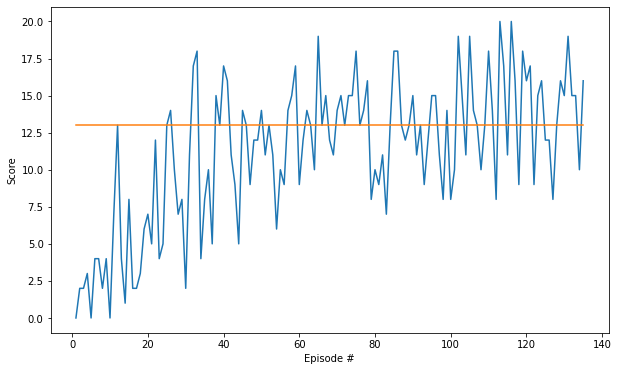

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), [13.] * len(scores))
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Finally, runing the following cell would simulate one run to demonstrate how the trained agent performs:

In [19]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0
while True:
    action = np.random.randint(action_size)
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break

print("Score: {}".format(score))

Score: 11.0


## Next steps

During our experiment, we haven't got around to thoroughly tune the hyper-parameters, or analyze how each extension to DQN separately affects the training process and agent performance.

It would also be interesting to experiment with all the other extensions to DQN that are described in Rainbow (Hessel et al. 2017), which effectively serves as the current baseline.

We also observed that the agent sometimes ignores a cluster of yellow bananas near it that it saw a few seconds ago, and instead chases after another banana that is currently visible but far away. This inefficiency is likely caused by the decision process not being fully Markovian, since the the agent can't even observe all directions around it at the same time. One solution would be introduce some kind of recurrent mechanism as described in Hausknecht and Stone (2015), so that the agent can remember what it has seen recently and act more efficiently.

## References

- Mnih, V. et al. (2015) ‘Human-level control through deep reinforcement learning’, Nature, 518(7540), pp. 529–533. doi: 10.1038/nature14236.
- Schaul, T. et al. (2015) ‘Prioritized Experience Replay’. Available at: http://arxiv.org/abs/1511.05952
- Wang, Z. et al. (2015) ‘Dueling Network Architectures for Deep Reinforcement Learning’. Available at: http://arxiv.org/abs/1511.06581
- Fortunato, M. et al. (2017) ‘Noisy Networks for Exploration’. Available at: https://arxiv.org/abs/1706.10295
- van Hasselt, H., Guez, A. and Silver, D. (2015) ‘Deep Reinforcement Learning with Double Q-learning’. Available at: http://arxiv.org/abs/1509.06461
- Hessel, M. et al. (2017) ‘Rainbow: Combining Improvements in Deep Reinforcement Learning’. Available at: http://arxiv.org/abs/1710.02298
- Hausknecht, M. and Stone, P. (2015) ‘Deep Recurrent Q-Learning for Partially Observable MDPs’. Available at: http://arxiv.org/abs/1507.06527